In [2]:
#imorting dependencies
import numpy as np
import sympy as sp
from sympy.utilities.lambdify import lambdify
from sympy.physics.quantum.dagger import Dagger


In [19]:
class variables:
    def __init__(self,d_cb,d_ba):
        self.gen_variables(d_cb,d_ba)
        self.gen_H()
        self.H_scaled = self.normalize(self.H) #here we decide which hamiltonian will get generated
        self.G_scaled = self.normalize(self.G)
        
    def gen_variables(self,d_cb,d_ba):   
        self.E_c    = sp.Symbol("E_c")
        self.E_b    = sp.Symbol("E_b")
        self.E_a    = sp.Symbol("E_a")

        self.h      = sp.Symbol("h")
        self.Om_cb  = sp.Symbol("\Omega_{cb}")
        self.Om_ba  = sp.Symbol("\Omega_{ba}")
        self.V_cb   = self.h*self.Om_cb/2
        self.V_ba   = self.h*self.Om_ba/2
        self.om_cb  = sp.Symbol("\omega_{L'}")
        self.om_ba  = sp.Symbol("\omega_{L}")
        self.I      = sp.Symbol("I")
        self.t      = sp.Symbol("t")
        self.e_cb_lower   = sp.exp(self.I*self.om_cb*self.t)
        self.e_cb_upper   = sp.exp(-self.I*self.om_cb*self.t)
        self.e_ba_lower   = sp.exp(self.I*self.om_ba*self.t)
        self.e_ba_upper   = sp.exp(-self.I*self.om_ba*self.t)
        
        self.d_cb   = sp.Symbol("\delta_{CB}")
        self.d_ba   = sp.Symbol("\delta_{BA}")
        
        self.n_3_   = self.h*self.om_cb/2
        self.n_8_   = (self.h/sp.sqrt(3))*(self.om_ba+self.om_cb/2)

        self.values = [(self.E_c,5/3),(self.E_b,2/3),(self.E_a,-(7/3)),(self.h,1),(self.d_cb,d_cb),(self.d_ba,d_ba),(self.Om_cb,0.2),(self.Om_ba,0.2),(self.om_cb,0),(self.om_ba,3),(self.I,1j)]
        
    def gen_H(self):
        self.H_A =sp.Matrix([
            [self.E_c,0,0],
            [0,self.E_b,0],
            [0,0,self.E_a]
        ])

        self.V_1 =self.V_cb*sp.Matrix([
            [0,              self.e_cb_upper,0],
            [self.e_cb_lower,0              ,0],
            [0,              0              ,0]
        ])
        self.V_2 =self.V_ba*sp.Matrix([
            [0, 0,                      0],
            [0,0         ,self.e_ba_upper],
            [0,self.e_ba_lower         ,0]
        ])
        
        self.lambda_3 = sp.Matrix([
            [1, 0, 0],
            [0,-1 ,0],
            [0, 0 ,0]
        ])
        self.lambda_8 = (1/sp.sqrt(3))*sp.Matrix([
            [1, 0 , 0],
            [0, 1 , 0],
            [0, 0 ,-2]
        ])
        self.lambda_1 = sp.Matrix([
            [0, 1 , 0],
            [1, 0 , 0],
            [0, 0 , 0]
        ])
        self.lambda_6 = sp.Matrix([
            [0, 0 , 0],
            [0, 0 , 1],
            [0, 1 , 0]
        ])
        self.G = (self.n_3_*self.lambda_3 + self.n_8_*self.lambda_8)
        self.H = (self.d_cb*self.lambda_3 + (1/sp.sqrt(3))*(2*self.d_ba+self.d_cb)*self.lambda_8+self.Om_cb*self.lambda_1+self.Om_ba*self.lambda_6)
    def Trace(self,H):
        s=0
        for i in range(H.shape[0]):
            s+=H[i,i]
        return s
    def normalize(self,H): #normalizing some input hamiltonian
        a=self.Trace(H*H)
        scale = sp.sqrt(a/2)
        H_scaled = H/scale
        return H_scaled

In [4]:

class SU_3:
    def __init__(self): #only valid for 3 dim
        #following is valid if the determinant of the generator does not vary
        #self.phi = self.det_to_phi(sp.det(H_sample))
        #generating coefficients:
        #self.C_1,self.C_2,self.C_3 = self.gen_coefficients(self.phi)
        #one extra thing: the unitary matrix:
        self.Identity =  sp.eye(3)
        
    def det_to_phi(self,H_det):
        phi  = sp.Symbol("\phi")
        res  = sp.solvers.solve((2/(3*sp.sqrt(3)))*sp.sin(3*phi)+H_det,phi)
        return min(res)
    
    def outside_brackets(self,phi,k): # used in self.gen_coefficients(phi)
        out_bra_u = (sp.exp((2/sp.sqrt(3))*1j*sp.Symbol("t")*(sp.sin(phi+(2*sp.pi*k)/3)))).evalf()
        out_bra_l = (1 - 2*sp.cos(2*(phi+(2*sp.pi*k)/3))).evalf()
        out_bra   = out_bra_u/out_bra_l
        return out_bra     
    
    def gen_coefficients(self,phi):
        C_1,C_2,C_3 = 0,0,0
        for k in range(3):
            out_bra = self.outside_brackets(phi,k)
            C_1+=out_bra
            C_2+=(2/sp.sqrt(3))*(sp.sin(phi+(2*sp.pi*k)/3))*out_bra
            C_3+=-(1/3)*(1+2*sp.cos(2*(phi+(2*sp.pi*k)/3)))*out_bra #sp.eye((self.H).shape[0])
        return C_1.evalf(),C_2.evalf(),C_3.evalf()

    def gen_unitary_m(self,H): #input H/h must be evaluated already (no t dependence)
        phi = self.det_to_phi(sp.det(H))
        C_1,C_2,C_3 = self.gen_coefficients(phi)
        return H*H*C_1+H*C_2+self.Identity*C_3




In [5]:
import matplotlib.pyplot as plt
class m_vectors:
    def __init__(self,RHO_EVOL):
        self.RHO_EVOL = RHO_EVOL
        self.gen_rho_el()
        self.m_l = self.gen_m()
    def gen_rho_el(self):
        self.rho_l =[
            [],
            [],
            [],
            [],
            [],
            [],
            [],
            [],
            [],
        ]
        for mat in self.RHO_EVOL:
            self.rho_l[0].append(complex(mat[0][0]))
            self.rho_l[1].append(complex(mat[0][1]))
            self.rho_l[2].append(complex(mat[0][2]))
            self.rho_l[3].append(complex(mat[1][0]))
            self.rho_l[4].append(complex(mat[1][1]))
            self.rho_l[5].append(complex(mat[1][2]))
            self.rho_l[6].append(complex(mat[2][0]))
            self.rho_l[7].append(complex(mat[2][1]))
            self.rho_l[8].append(complex(mat[2][2]))
        self.rho_l = [np.array(el) for el in self.rho_l]
    def gen_m(self):
        arr = []
        arr.append(np.sqrt(3)*np.real(self.rho_l[1]))
        arr.append(np.sqrt(3)*np.imag(self.rho_l[1]))
        arr.append((np.sqrt(3)/(2))*np.real(self.rho_l[0]-self.rho_l[4]))
        arr.append(np.sqrt(3)*np.real(self.rho_l[2]))
        arr.append(np.sqrt(3)*np.imag(self.rho_l[2]))
        arr.append(np.sqrt(3)*np.real(self.rho_l[5]))
        arr.append(np.sqrt(3)*np.imag(self.rho_l[5]))
        arr.append((1/2)*(1-3*np.real(self.rho_l[8])))
        return arr

In [6]:
class plotting_m:
    def __init__(self,m_l):
        self.m_l = m_l

    def circle(self):
        theta = np.linspace(0,2*np.pi,100)
        x= np.cos(theta)
        y= np.sin(theta)
        plt.plot(x,y) # outer boundary
        plt.plot((1/2)*x,(1/2)*y) # inner boundary
        plt.plot((1/np.sqrt(3))*x,(1/np.sqrt(3))*y) # middle boundary

    def plot_cartan(self):
        plt.figure(figsize=[10, 10])
        plt.plot(self.m_l[2],self.m_l[7],'g:')
        plt.plot([-np.sqrt(3)/2,np.sqrt(3)/2],[1/2,1/2],'b')
        plt.plot([0,-np.sqrt(3)/2],[-1,1/2],'b')
        plt.plot([0,np.sqrt(3)/2],[-1,1/2],'b')
        
        self.circle()
        
        plt.text(np.sqrt(3)/2+0.01, 1/2, 'state C', fontsize=12)
        plt.text(-np.sqrt(3)/2-0.14, 1/2, 'state B', fontsize=12)
        plt.text(-0.045, -1-0.1, 'state A', fontsize=12)
        D = 1 #the displacement size of the plot
        plt.axis([-1/2-D, 1/2+D, -1.2-D, 2/3+D])
        plt.xlabel("m_3",fontsize=16)
        plt.ylabel("m_8",fontsize=16)
        plt.title("Evolution of a 3-level quantum system",fontsize=16)
        plt.show()
    def plot_1_2(self):
        plt.figure(figsize=[10, 10])
        plt.plot(self.m_l[0],self.m_l[1],'g:')
        plt.axis([-2, 2, -2, 2])
        self.circle()
        plt.show()
    def plot_4_5(self):
        plt.figure(figsize=[10, 10])
        plt.plot(self.m_l[3],self.m_l[4],'g:')
        plt.axis([-2, 2, -2, 2])
        self.circle()
        plt.show()
    def plot_6_7(self):
        plt.figure(figsize=[10, 10])
        plt.plot(self.m_l[5],self.m_l[6],'g:')
        plt.axis([-2, 2, -2, 2])
        self.circle()
        plt.show()
    def plot_1_8(self):
        plt.figure(figsize=[10, 10])
        plt.plot(self.m_l[0],self.m_l[7],'g:')
        plt.axis([-2, 2, -2, 2])
        self.circle()
        plt.show()
    def plot_3_4(self):
        plt.figure(figsize=[10, 10])
        plt.plot(self.m_l[2],self.m_l[3],'g:')
        plt.axis([-2, 2, -2, 2])
        self.circle()
        plt.show()
    def plot_4_8(self):
        plt.figure(figsize=[10, 10])
        plt.plot(self.m_l[3],self.m_l[7],'g:')
        plt.axis([-2, 2, -2, 2])
        self.circle()
        plt.show()

In [7]:
class plotting_m_2:
    def __init__(self):
        print("plotting_m_2 initialized")
    def circle(self,ax):
        theta = np.linspace(0,2*np.pi,100)
        x= np.cos(theta)
        y= np.sin(theta)
        ax.plot(x,y) # outer boundary
        ax.plot((1/2)*x,(1/2)*y) # inner boundary
        ax.plot((1/np.sqrt(3))*x,(1/np.sqrt(3))*y) # middle boundary
        ax.plot([0],[0],marker="o", markersize=3, color="blue")

    def plot_cartan(self,ax):
        ax.plot([-np.sqrt(3)/2,np.sqrt(3)/2],[1/2,1/2],'b')
        ax.plot([0,-np.sqrt(3)/2],[-1,1/2],'b')
        ax.plot([0,np.sqrt(3)/2],[-1,1/2],'b')
        ax.text(np.sqrt(3)/2+0.01, 1/2+0.02, 'state C', fontsize=12)
        ax.text(-np.sqrt(3)/2-0.14, 1/2+0.02, 'state B', fontsize=12)
        ax.text(-0.045, -1-0.1, 'state A', fontsize=12)
        
        D = 1.2 #the displacement size of the plot
        ax.axis([-D, D, -D, D])
        #axis.xlabel("m_3",fontsize=16)
        #axis.ylabel("m_8",fontsize=16)

    def plot_m_n(self,m,n,ax,text):
        ax.plot(m,n,label = text)
        ax.legend()
        

In [8]:



class run:
    def __init__(self,d_cb,d_ba,rho_):
        self.d_cb = d_cb
        self.d_ba = d_ba
        self.rho_ = rho_
    def RUN(self,start,end):
        objects = variables(self.d_cb,self.d_ba)
        H_scaled = objects.H_scaled.subs(objects.values)
        G_scaled = objects.G_scaled.subs(objects.values)


        matrix_to_unitary = SU_3()
        U = matrix_to_unitary.gen_unitary_m(H_scaled)
        T = matrix_to_unitary.gen_unitary_m(G_scaled)

        U_fun =  lambdify(sp.Symbol("t"),U)
        T_fun =  lambdify(sp.Symbol("t"),T)


        t = np.linspace(start,end,1000)
        U_list  = [sp.Matrix(U_fun(t_)) for t_ in t]
        T_list  = [sp.Matrix(T_fun(t_)) for t_ in t]

        #generates the evolution of rho:
        #rho = gen_rho_0()
        #RHO_EVOL = list(map(self.transform2,U_list,T_list))
        RHO_EVOL = list(map(self.transform,U_list))

        #for plotting
        m_inst = m_vectors(RHO_EVOL)
        #c.append(max(m_inst.rho_l[0]))
        m_l = m_inst.m_l
        """plotting = plotting_m(m_l)
        plotting.plot_cartan()
        plotting.plot_1_2()
        plotting.plot_4_5()
        plotting.plot_6_7()
        plotting.plot_1_8()
        plotting.plot_3_4()
        plotting.plot_4_8()"""
        return m_inst #m_l
    def transform(self,U):
        U_dagg = Dagger(U)
        rho_evol = U*self.rho_*U_dagg
        return np.array(rho_evol)
    def transform2(self,U,T):
        U_dagg = Dagger(U)
        T_dagg = Dagger(T)
        rho_evol = T_dagg*U*self.rho_*U_dagg*T
        return np.array(rho_evol)




In [9]:
def gen_rho_0():
    rho = sp.Matrix([ #for coherences, i think that the max is 1/3
        [0,0,0],
        [0,1/2,0],
        [ 0, 0, 1/2]
    ])
    return rho
def gen_rho_0_2():
    rho = sp.Matrix([ #for coherences, i think that the max is 1/3
        [0,0,0],
        [0,1,0],
        [0,0,0]
    ])
    return rho

def gen_rho_0_3():
    rho = sp.Matrix([ #for coherences, i think that the max is 1/3
        [0,1/3,0],
        [1/3,0,0],
        [0,0,0]
    ])
    return rho
def gen_rho_0_4():
    rho = sp.Matrix([ #for coherences, i think that the max is 1/3
        [1/2,0,0],
        [0,1/2,0],
        [0,0,0]
    ])
    return rho
def gen_rho_0_5():
    rho = sp.Matrix([ #for coherences, i think that the max is 1/3
        [1/3+0.05,0,0],
        [0,1/3-0.025,0],
        [0,0,1/3-0.025]
    ])
    return rho
def gen_rho_0_6():
    rho = sp.Matrix([ #for coherences, i think that the max is 1/3
        [1,0,0],
        [0,0,0],
        [ 0, 0, 0]
    ])
    return rho


In [10]:
def reshape_N_to_row_col(N,M): # col'th column, row'th row, M are the number of columns
    col = N%M
    row = int(N/M)
    return row,col

import itertools as it
l = list(it.combinations("01234567",2)) #list of length 28



In [20]:
rho_0 = gen_rho_0_6()
inst_BA = run(0,0.1,rho_0) #d_cb, d_ba, rho_0
m_inst =inst_BA.RUN(0,40)
m_l = m_inst.m_l
plotting = plotting_m_2()


plotting_m_2 initialized


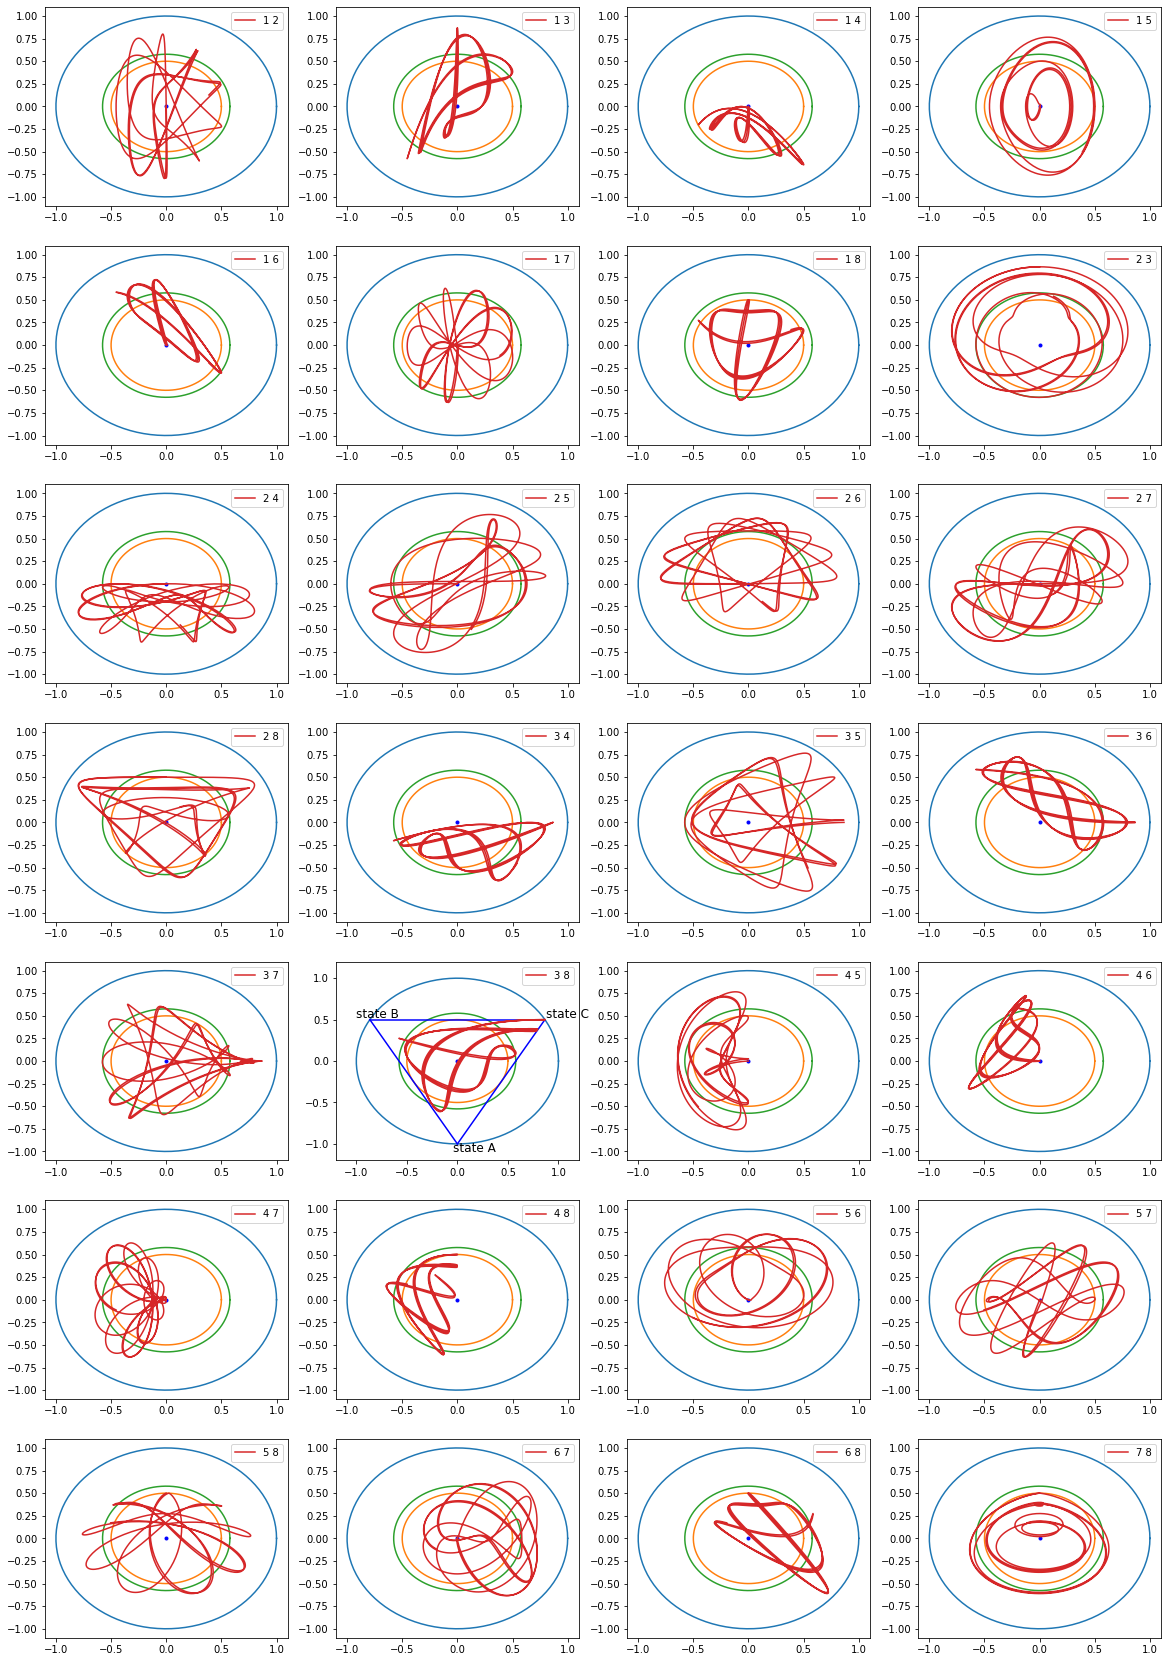

In [21]:
%matplotlib inline
fig, axs = plt.subplots(7,4)
fig.set_size_inches(20, 30)
for N in range(28):
    row,col = reshape_N_to_row_col(N,4)
    plotting.circle(axs[row,col])
    
    indices = l[N]
    m = int(indices[0])
    n = int(indices[1])
    if m==2 and n==7:
        plotting.plot_cartan(axs[row][col])
    text = str(m+1) + " " + str(n+1)
    plotting.plot_m_n(m_l[m],m_l[n],axs[row][col],text)


In [13]:
def convert_2m_to_1M(ma,mb):
    return np.sqrt(ma*ma+mb*mb)
l2 = list(it.combinations("abcK",2)) #list of length 6
l2


[('a', 'b'), ('a', 'c'), ('a', 'K'), ('b', 'c'), ('b', 'K'), ('c', 'K')]

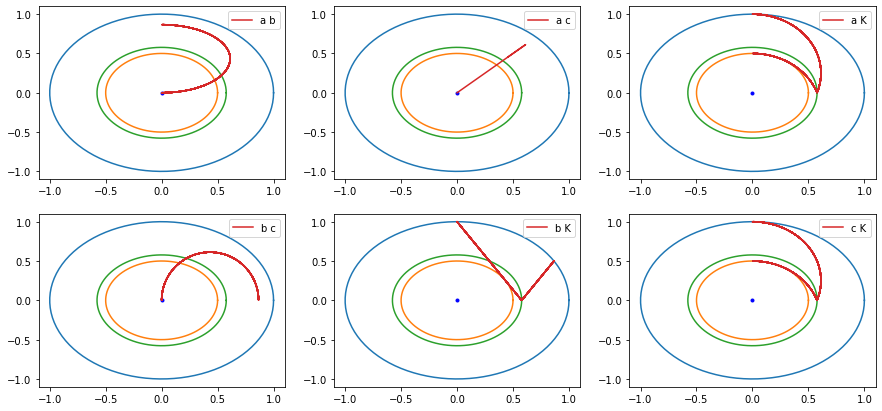

In [14]:
%matplotlib inline
dictt = {"a":[0,1],"b":[3,4],"c":[5,6],"K":[2,7]}
fig, axs = plt.subplots(2,3)
fig.set_size_inches(15, 7)
for N in range(6):
    row,col = reshape_N_to_row_col(N,3)
    plotting.circle(axs[row,col])
    
    indices_ = l2[N]

    first=dictt[indices_[0]]
    X=convert_2m_to_1M(m_l[first[0]],m_l[first[1]])
    second=dictt[indices_[1]]
    Y=convert_2m_to_1M(m_l[second[0]],m_l[second[1]])  
    text = indices_[0] + " " + indices_[1]
    plotting.plot_m_n(X,Y,axs[row][col],text)

In [15]:
import json
def convert_to_rho(rho_arr): #takes an array of rho, and converts it into a numpy matrix
    return np.array([
        [rho_arr[0],rho_arr[1]+1j*rho_arr[7],rho_arr[2]+1j*rho_arr[8]],
        [rho_arr[1]-1j*rho_arr[7],rho_arr[3],rho_arr[4]+1j*rho_arr[10]],
        [rho_arr[2]-1j*rho_arr[8],rho_arr[4]-1j*rho_arr[10],rho_arr[5]]
    ])
def load_rho(filename):
    with open(filename) as json_file:
        data = json.load(json_file)
        sep = ","
        rho_evall = []
        for p in data['rho']:
            rho_evall.append([float(el) for el in p.split(sep)])
    return rho_evall

        

In [16]:

#this code downloads and reformats numerical results
"""rho_evoll = load_rho("data.txt")
rho_evoll = np.array([convert_to_rho(el) for el in rho_evoll])

rho_evoll2 = load_rho("data2.txt")
rho_evoll2 = np.array([convert_to_rho(el) for el in rho_evoll2])"""

'rho_evoll = load_rho("data.txt")\nrho_evoll = np.array([convert_to_rho(el) for el in rho_evoll])\n\nrho_evoll2 = load_rho("data2.txt")\nrho_evoll2 = np.array([convert_to_rho(el) for el in rho_evoll2])'

In [17]:
#this code is for plotting numerical vs analytical results
"""%matplotlib qt 

rho_0_BA = gen_rho_0()
rho_0_B = gen_rho_0_2()
d_cb = 0.1
inst_BA = run(d_cb,rho_0_BA)
inst_B = run(d_cb,rho_0_B)
m_l_BA =inst_BA.RUN()
m_l_B = inst_B.RUN()

m_inst_num_1 = m_vectors(rho_evoll)
m_l_num_BA = m_inst_num_1.m_l

m_inst_num_2 = m_vectors(rho_evoll2)
m_l_num_B = m_inst_num_2.m_l

plotting = plotting_m_2()
fig, axs = plt.subplots(1,2)
fig.set_size_inches(14, 7)
for i in range(2):
    plotting.plot_cartan(axs[i])
    plotting.circle(axs[i])
plotting.plot_m_n(m_l_num_BA[2],m_l_num_BA[7],axs[0],"starting in sup. pos. of B and A")
plotting.plot_m_n(m_l_num_B[2],m_l_num_B[7],axs[0],"starting in B")

plotting.plot_m_n(m_l_BA[2],m_l_BA[7],axs[1],"starting in sup. pos. of B and A")
plotting.plot_m_n(m_l_B[2],m_l_B[7],axs[1],"starting in B")
fig.suptitle("Comparison between numerical and analytical solutions",fontsize =20)
axs[0].set_title("The numerical results",fontsize = 16)
axs[1].set_title("The analytical results",fontsize = 16)"""

'%matplotlib qt \n\nrho_0_BA = gen_rho_0()\nrho_0_B = gen_rho_0_2()\nd_cb = 0.1\ninst_BA = run(d_cb,rho_0_BA)\ninst_B = run(d_cb,rho_0_B)\nm_l_BA =inst_BA.RUN()\nm_l_B = inst_B.RUN()\n\nm_inst_num_1 = m_vectors(rho_evoll)\nm_l_num_BA = m_inst_num_1.m_l\n\nm_inst_num_2 = m_vectors(rho_evoll2)\nm_l_num_B = m_inst_num_2.m_l\n\nplotting = plotting_m_2()\nfig, axs = plt.subplots(1,2)\nfig.set_size_inches(14, 7)\nfor i in range(2):\n    plotting.plot_cartan(axs[i])\n    plotting.circle(axs[i])\nplotting.plot_m_n(m_l_num_BA[2],m_l_num_BA[7],axs[0],"starting in sup. pos. of B and A")\nplotting.plot_m_n(m_l_num_B[2],m_l_num_B[7],axs[0],"starting in B")\n\nplotting.plot_m_n(m_l_BA[2],m_l_BA[7],axs[1],"starting in sup. pos. of B and A")\nplotting.plot_m_n(m_l_B[2],m_l_B[7],axs[1],"starting in B")\nfig.suptitle("Comparison between numerical and analytical solutions",fontsize =20)\naxs[0].set_title("The numerical results",fontsize = 16)\naxs[1].set_title("The analytical results",fontsize = 16)'

In [18]:
"""rho_0_BA = gen_rho_0()
rho_0_B = gen_rho_0_2()
d_cb_l =[0.4,0.2,0.15,0.1,0.05,0]
M_l=[]
for d_cb in d_cb_l: 
    inst_BA = run(d_cb,rho_0_BA)
    inst_B = run(d_cb,rho_0_B)
    m_l_BA =inst_BA.RUN()
    m_l_B = inst_B.RUN()
    M_l.append([m_l_BA,m_l_B])"""


'rho_0_BA = gen_rho_0()\nrho_0_B = gen_rho_0_2()\nd_cb_l =[0.4,0.2,0.15,0.1,0.05,0]\nM_l=[]\nfor d_cb in d_cb_l: \n    inst_BA = run(d_cb,rho_0_BA)\n    inst_B = run(d_cb,rho_0_B)\n    m_l_BA =inst_BA.RUN()\n    m_l_B = inst_B.RUN()\n    M_l.append([m_l_BA,m_l_B])'

In [19]:
#plotting different values for the frequency
"""%matplotlib qt
plotting = plotting_m_2()
fig, axs = plt.subplots(3,2)
fig.set_size_inches(15, 10)
for i, m_l in enumerate(M_l):
    I = int(i/2)
    J = i%2
    plotting.plot_cartan(axs[I][J])
    plotting.circle(axs[I][J])
    plotting.plot_m_n(m_l[0][2],m_l[0][7],axs[I][J],"starting in sup. pos. of B and A")
    plotting.plot_m_n(m_l[1][2],m_l[1][7],axs[I][J],"starting in B")
    axs[I][J].set_title(r"$\delta_{CB}=\pm$"+str(d_cb_l[i]),fontsize = 16)

fig.suptitle(r"Evolution of the states for varying $\delta_{CB}$",fontsize =20)"""


'%matplotlib qt\nplotting = plotting_m_2()\nfig, axs = plt.subplots(3,2)\nfig.set_size_inches(15, 10)\nfor i, m_l in enumerate(M_l):\n    I = int(i/2)\n    J = i%2\n    plotting.plot_cartan(axs[I][J])\n    plotting.circle(axs[I][J])\n    plotting.plot_m_n(m_l[0][2],m_l[0][7],axs[I][J],"starting in sup. pos. of B and A")\n    plotting.plot_m_n(m_l[1][2],m_l[1][7],axs[I][J],"starting in B")\n    axs[I][J].set_title(r"$\\delta_{CB}=\\pm$"+str(d_cb_l[i]),fontsize = 16)\n\nfig.suptitle(r"Evolution of the states for varying $\\delta_{CB}$",fontsize =20)'

In [20]:
#can delete
"""rho_0 = gen_rho_0()

d_cb_l =np.linspace(-0.4,0.4,10)#[0.4,0.2,0.15,0.1,0.05,0]
rho_cc_2 = []
for d_cb in d_cb_l: 
    print("a")
    inst = run(d_cb,rho_0)
    m_inst =inst.RUN()
    ind = np.where(m_inst.rho_l[0]==max(m_inst.rho_l[0]))[0][0]
    rho_cc_2.append(m_inst.rho_l[0][ind])
    #rho_diag.append(np.array([np.real(m_inst.rho_l[0][ind]),np.real(m_inst.rho_l[4][ind]),np.real(m_inst.rho_l[8][ind])]))

"""

'rho_0 = gen_rho_0()\n\nd_cb_l =np.linspace(-0.4,0.4,10)#[0.4,0.2,0.15,0.1,0.05,0]\nrho_cc_2 = []\nfor d_cb in d_cb_l: \n    print("a")\n    inst = run(d_cb,rho_0)\n    m_inst =inst.RUN()\n    ind = np.where(m_inst.rho_l[0]==max(m_inst.rho_l[0]))[0][0]\n    rho_cc_2.append(m_inst.rho_l[0][ind])\n    #rho_diag.append(np.array([np.real(m_inst.rho_l[0][ind]),np.real(m_inst.rho_l[4][ind]),np.real(m_inst.rho_l[8][ind])]))\n\n'

In [21]:
"""S = []
for el in rho_diag:
    S.append(-sum(el*np.log(el)))
plt.plot(d_cb_l,S)
plt.show()"""

'S = []\nfor el in rho_diag:\n    S.append(-sum(el*np.log(el)))\nplt.plot(d_cb_l,S)\nplt.show()'

In [22]:
"""rho_cc =np.real(np.array(rho_cc))
plt.plot(d_cb_l,rho_cc,label=r"transition to state $C$")
plt.plot(d_cb_l,rho_cc_2,label=r"transition to state $C$")
plt.title(r"Maximal probabilities for the state $C$",fontsize= 20)
plt.xlabel(r"$\delta_{CB}$",fontsize= 16)
plt.ylabel("probability",fontsize= 16)"""

'rho_cc =np.real(np.array(rho_cc))\nplt.plot(d_cb_l,rho_cc,label=r"transition to state $C$")\nplt.plot(d_cb_l,rho_cc_2,label=r"transition to state $C$")\nplt.title(r"Maximal probabilities for the state $C$",fontsize= 20)\nplt.xlabel(r"$\\delta_{CB}$",fontsize= 16)\nplt.ylabel("probability",fontsize= 16)'

In [23]:
"""rho_0_BA = gen_rho_0()
d_cb = 0.1

inst_BA = run(d_cb,0,rho_0_BA)

m_l_BA =inst_BA.RUN(0,10)
"""

'rho_0_BA = gen_rho_0()\nd_cb = 0.1\n\ninst_BA = run(d_cb,0,rho_0_BA)\n\nm_l_BA =inst_BA.RUN(0,10)\n'

<IPython.core.display.Javascript object>


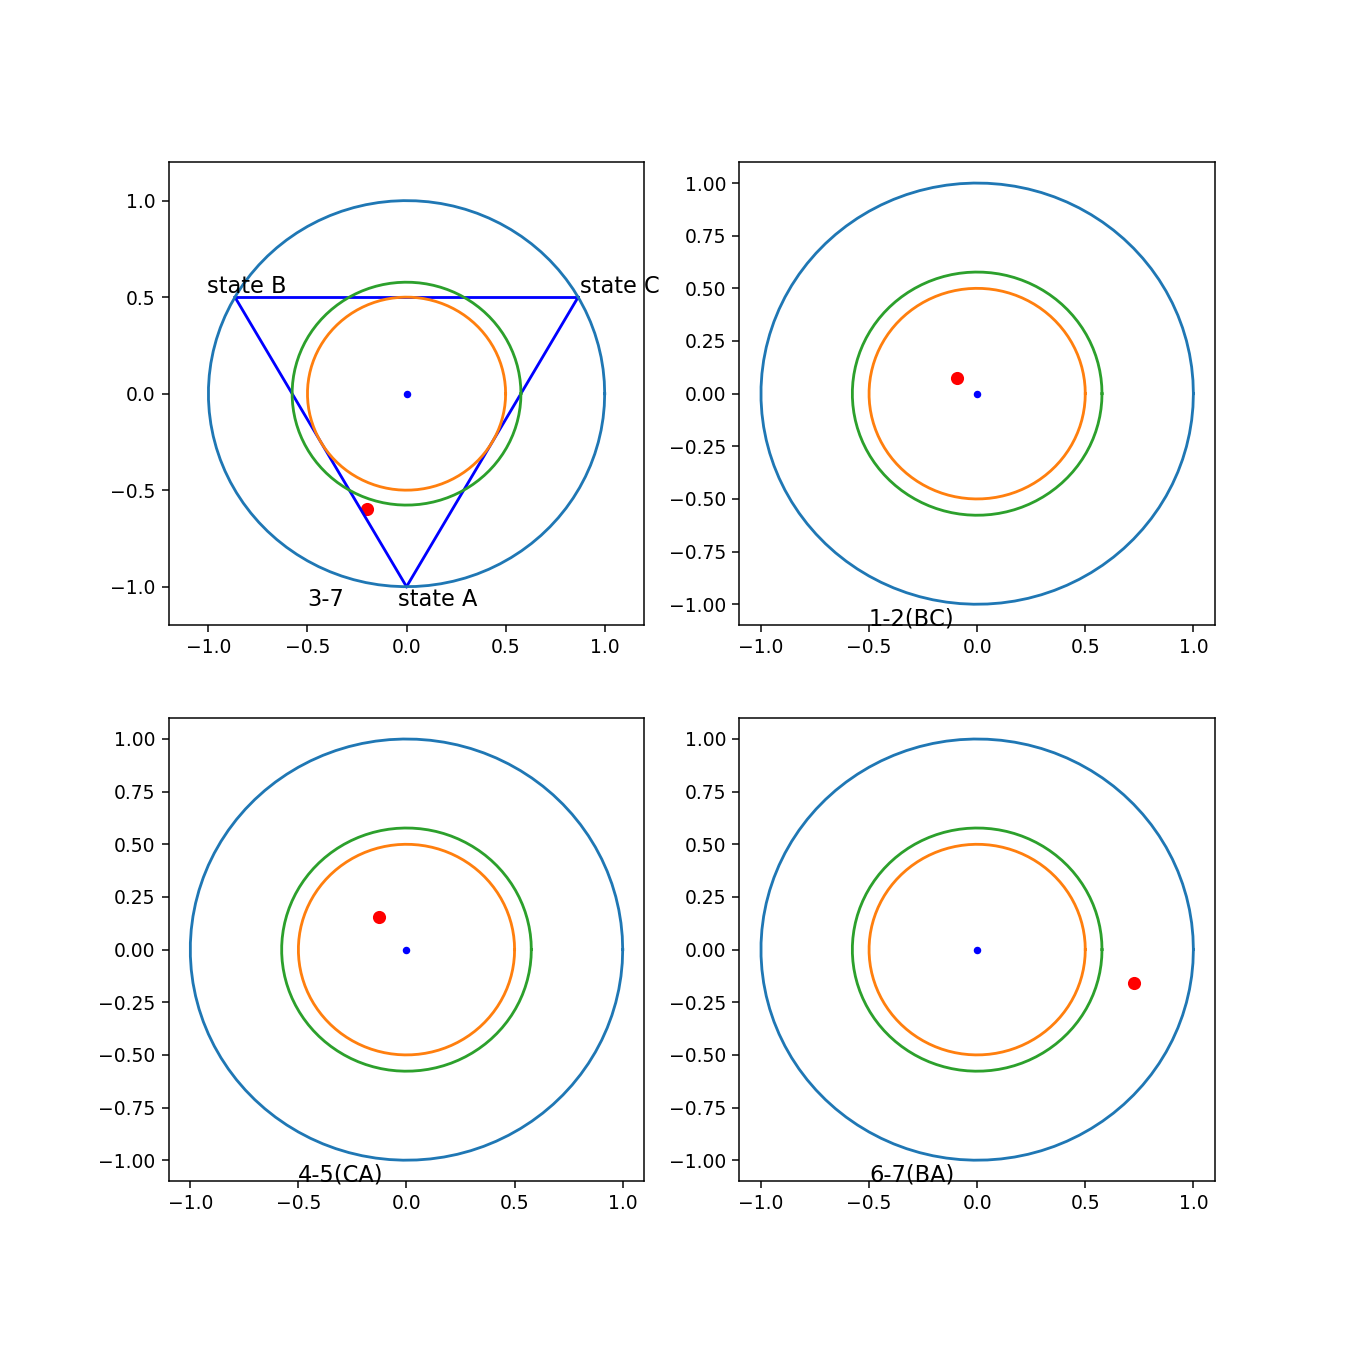

In [22]:
import matplotlib.animation as animation
%matplotlib notebook

# Set up formatting for the movie files
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

MX = m_l[2]
MY = m_l[7]

MX2 = m_l[0]
MY2 = m_l[1]

MX3 = m_l[3]
MY3 = m_l[4]

MX4 = m_l[5]
MY4 = m_l[6]

fig, axss = plt.subplots(2,2)
fig.set_size_inches(10, 10)
line1, = axss[0][0].plot([MX[0]], [MY[0]],"ro")
line2, = axss[0][1].plot([MX2[0]], [MY2[0]],"ro")
line3, = axss[1][0].plot([MX3[0]], [MY3[0]],"ro")
line4, = axss[1][1].plot([MX4[0]], [MY4[0]],"ro")

plotting.plot_cartan(axss[0][0])
plotting.circle(axss[0][0])
plotting.circle(axss[0][1])
plotting.circle(axss[1][0])
plotting.circle(axss[1][1])
axss[0,0].text(-0.5, -1-0.1, "3-7", fontsize=12)
axss[0,1].text(-0.5, -1-0.1, "1-2(BC)", fontsize=12)
axss[1,0].text(-0.5, -1-0.1, "4-5(CA)", fontsize=12)
axss[1,1].text(-0.5, -1-0.1, "6-7(BA)", fontsize=12)
def animate(i):
    line1.set_data(MX[i], MY[i])
    line2.set_data(MX2[i], MY2[i])
    line3.set_data(MX3[i], MY3[i])
    line4.set_data(MX4[i], MY4[i])
    return line1,line2,line3,line4


ani = animation.FuncAnimation(fig, animate, np.arange(0,1000),#0,161 
    interval=50, blit=True,repeat=True)
#ani.save('im.mp4',writer=writer)
#print("saved")
plt.show()

<IPython.core.display.Javascript object>


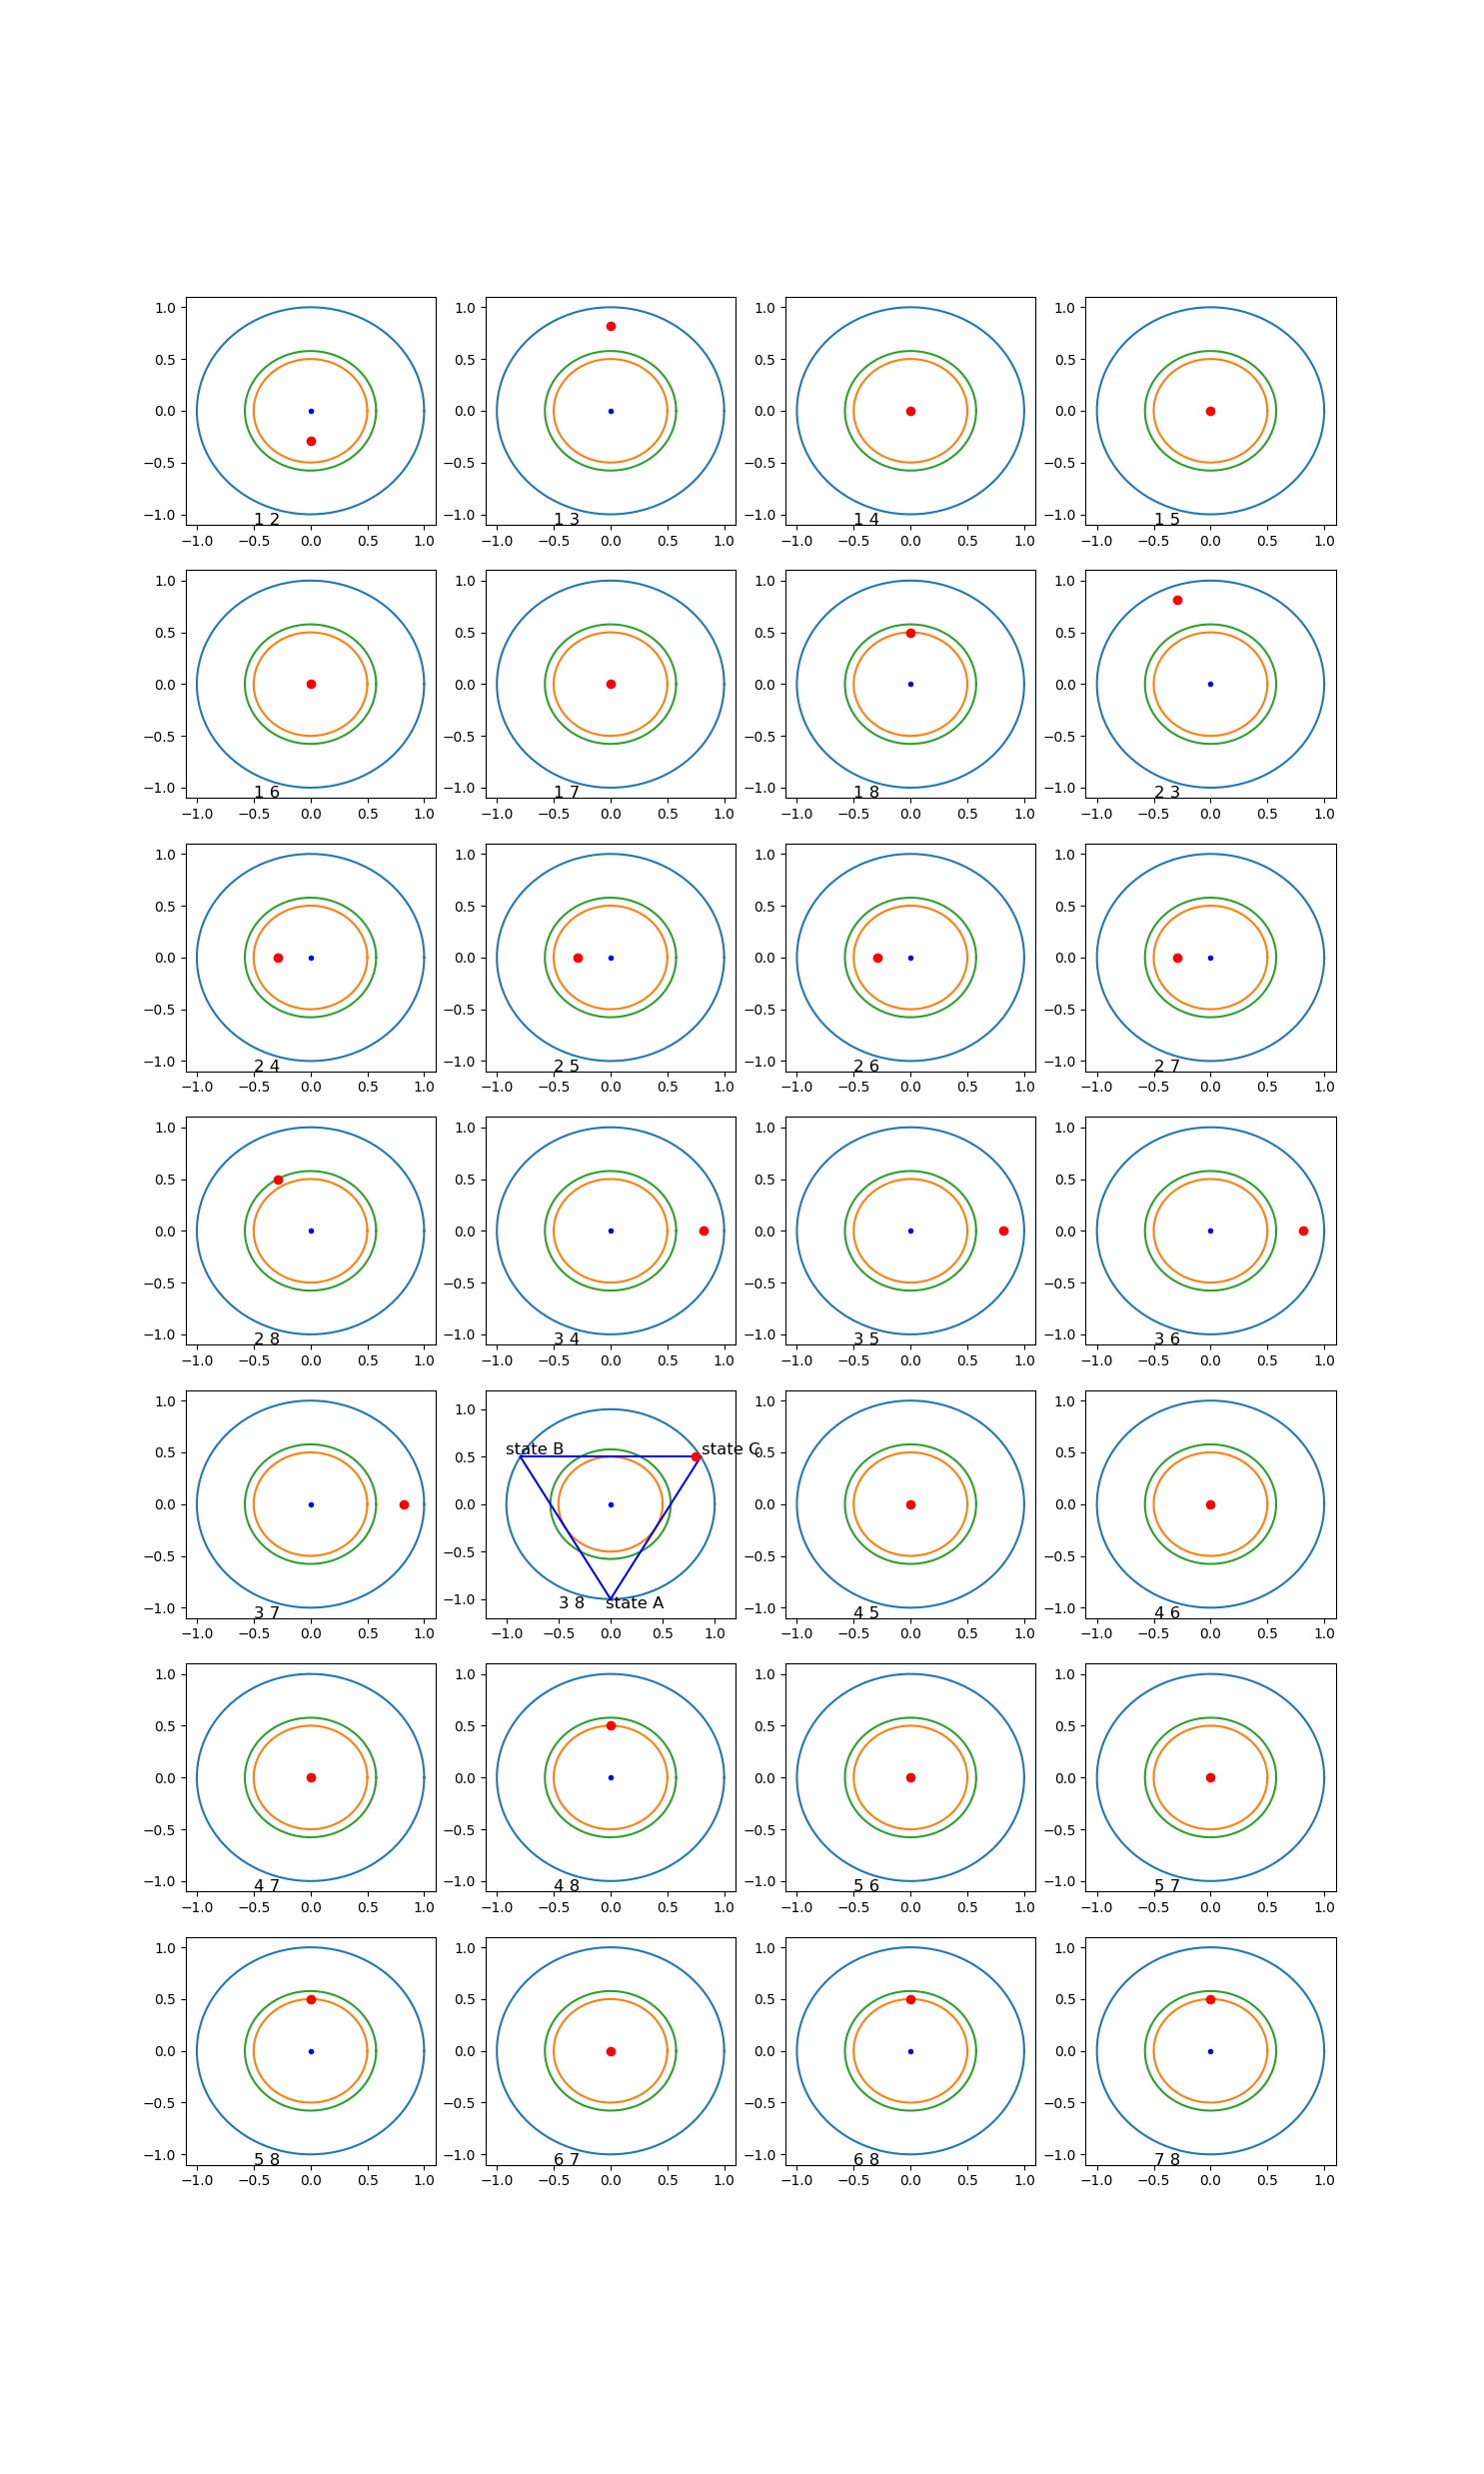

video saved


In [26]:
#plotting every possible subspace
import matplotlib.animation as animation
%matplotlib notebook

Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

MX = m_l[2]
MY = m_l[7]

MX2 = m_l[0]
MY2 = m_l[1]

fig, axs = plt.subplots(7,4)
fig.set_size_inches(15, 25)
lines = []
#drawing the static things
for N in range(28):
    row,col = reshape_N_to_row_col(N,4)
    plotting.circle(axs[row,col])
    
    indices = l[N]
    m = int(indices[0])
    n = int(indices[1])
    if m==2 and n==7:
        plotting.plot_cartan(axs[row][col])
    text = str(m+1) + " " + str(n+1)
    #plotting.plot_m_n(m_l[m],m_l[n],axs[row][col],text)
    #axs[row,col].text("text")
    lines.append(axs[row,col].plot([m_l[m][0]],[m_l[n][0]],"ro"))
    axs[row,col].text(-0.5, -1-0.1, text, fontsize=12)


def animate(i):
    for N in range(28):
        row,col = reshape_N_to_row_col(N,4)

        indices = l[N]
        m = int(indices[0])
        n = int(indices[1])

        lines[N][0].set_data(m_l[m][i],m_l[n][i])
        

    return lines


ani = animation.FuncAnimation(fig, animate, np.arange(0,161),
    interval=30, blit=True,repeat=True)
#ani.save('im.mp4',writer=writer)
print("video saved")
plt.show()